# Hand Gesture Recognition with a Convolutional Neural Network
## Training a convolutional neural network to classify images of hand gestures into "fist", "okay", and "other" based on Deep Learning with Python, 2nd edition, by François Chollet.

The dataset used is Hand Gesture Recognition Image Dataset (HaGRID) on Kaggle.

In [ ]:
# Import
import tensorflow as tf
from tensorflow import keras
import numpy
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from keras import models

In [ ]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## 1. Data preprocessing
### 1.1 Downloading the dataset and organizing in folders

Pictures are downloaded from https://www.kaggle.com/datasets/kapitanov/hagrid and are in RGB format. The folder is nested inside a data directory, which is under gitignore.

In [35]:
import os, shutil, pathlib, random

# 6K, 2K, 2K TESTING SPLIT

seed = 1337
random.seed(seed)
original_dir = pathlib.Path("data/hagrid_dataset_512")
new_base_dir = pathlib.Path(f"data/hagrid_6k_2k_2k_seed{seed}")

# Extract gesture list
gestures = []
for gesture in os.listdir(original_dir):
    gestures.append(gesture)
gestures.remove(".DS_Store")

print(gestures)

# Create gesture lists and randomly shuffle them
files_dict = {}
for gesture in gestures:
    files_dict[f"{gesture}_files"] = [file for file in os.listdir(original_dir / gesture) if file.endswith(".jpg")]
for files in files_dict:
    random.shuffle(files_dict[files])

# Function to make subset
def make_subset(subset_name, start_index, end_index):
    for category in gestures:
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = files_dict[f"{category}_files"][start_index:end_index]
        for fname in fnames:
            shutil.copyfile(src=original_dir / category / fname,
                            dst=dir / fname)

['dislike', 'like', 'stop_inverted', 'ok', 'mute', 'two_up', 'stop', 'peace', 'two_up_inverted', 'three', 'three2', 'call', 'one', 'rock', 'peace_inverted', 'fist', 'palm', 'four']


In [ ]:
# Make training, validation, and testing subsets
make_subset("train", start_index=0, end_index=6000)
make_subset("validation", start_index=6000, end_index=8000)
make_subset("test", start_index=8000, end_index=10000)

In [ ]:
# Turn subsets into keras datasets
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=128)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=128)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=128)

In [ ]:
# Extract one batch of images and labels from the train dataset
for images, labels in train_dataset.take(1):
    # Take the first image in the batch
    first_image = images[3].numpy().astype("uint8")
    
    # Display the image
    plt.imshow(first_image)
    plt.axis("off")  # Turn off the axis
    plt.show()

## 1.2 Data preprocessing

In [ ]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## 2. Building the model

The expected model input is a **grayscale** image of size **180 x 180**.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(18, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_H6k2k2k_061724_best.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                  patience=5, 
                                  restore_best_weights=True, 
                                  verbose=1),
    keras.callbacks.TensorBoard(log_dir='./logs', 
                                write_graph=True, 
                                write_images=True)
]

In [ ]:
model = keras.models.load_model("convnet_H6k2k2k_061724_best.keras")

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

## 3. Evaluation

In [ ]:
test_model = keras.models.load_model("convnet_H6k2k2k_061724_best.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# ACCURACY 88.19%
# LOSS 0.3853

[[[0.04313726 0.20784314 0.3019608 ]
  [0.09803922 0.23529412 0.3137255 ]
  [0.05882353 0.20784314 0.2509804 ]
  ...
  [0.13725491 0.30588236 0.32941177]
  [0.15294118 0.3529412  0.36862746]
  [0.16862746 0.33333334 0.38039216]]

 [[0.06666667 0.22745098 0.29803923]
  [0.09803922 0.22745098 0.28627452]
  [0.07450981 0.21960784 0.25490198]
  ...
  [0.16078432 0.33333334 0.34509805]
  [0.18431373 0.36862746 0.39215687]
  [0.18431373 0.3529412  0.3882353 ]]

 [[0.07843138 0.23529412 0.27450982]
  [0.07058824 0.19607843 0.23921569]
  [0.0627451  0.19215687 0.21960784]
  ...
  [0.19215687 0.36862746 0.38039216]
  [0.2        0.3764706  0.39607844]
  [0.1882353  0.34509805 0.3764706 ]]

 ...

 [[0.10588235 0.2509804  0.3254902 ]
  [0.03137255 0.17254902 0.27450982]
  [0.06666667 0.20784314 0.29411766]
  ...
  [0.         0.05882353 0.18039216]
  [0.         0.05882353 0.1882353 ]
  [0.01176471 0.06666667 0.20392157]]

 [[0.08235294 0.22745098 0.3019608 ]
  [0.04705882 0.1882353  0.2901961 ]


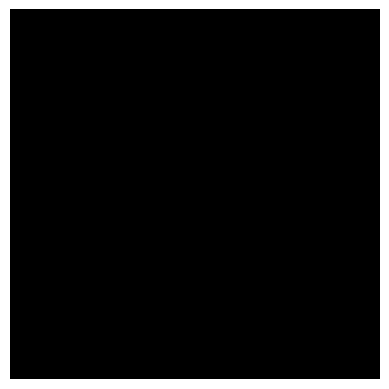

In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_dir = "data/hagrid_6k_2k_2k_seed1337/validation/call/0af8cf80-4ca2-44c3-accf-25cb3e9c21ea.jpg"
img = image.load_img(img_dir, target_size=(180, 180))
img_array = image.img_to_array(img)
img_tensor = np.expand_dims(img_array, axis=0)
img_tensor /= 255.0

plt.imshow(img_array.astype('uint8'))
plt.axis('off')  # Turn off the axis
plt.show()

# test_model.predict(img_tensor)

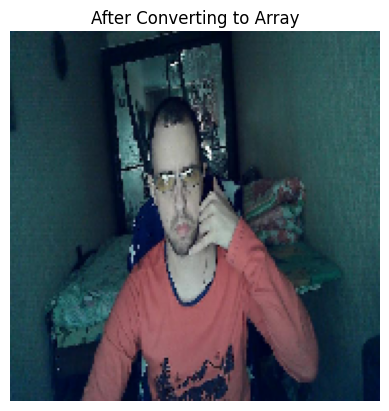

In [30]:
# Define the image path
img_dir = "data/hagrid_6k_2k_2k_seed1337/validation/call/0af8cf80-4ca2-44c3-accf-25cb3e9c21ea.jpg"

# Step 1: Load the image with the target size
img = image.load_img(img_dir, target_size=(180, 180))
plt.imshow(img)
plt.title("After Loading")
plt.axis('off')  # Turn off the axis
plt.show()

# Step 2: Convert the image to a numpy array
img_array = image.img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.title("After Converting to Array")
plt.axis('off')  # Turn off the axis
plt.show()

# Step 3: Normalize the image array
img_tensor = np.expand_dims(img_array, axis=0)
img_tensor /= 255.0

# Display the image after normalization (Note: Normalized image values are not in the range for direct display)
plt.imshow(img_tensor[0])
plt.title("After Normalizing")
plt.axis('off')  # Turn off the axis
plt.show()

Loading model...
Image tensor shape: (1, 180, 180, 3)


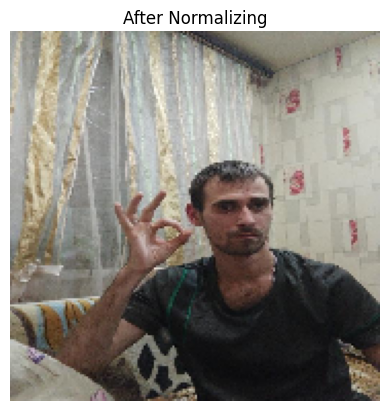

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Raw predictions: [[0.02857088 0.07036357 0.03754408 0.07084864 0.06094721 0.07836507
  0.05250162 0.04923061 0.07291178 0.08233721 0.0368152  0.0491046
  0.06227323 0.03873375 0.07004977 0.03916842 0.03631659 0.06391779]]
Softmax predictions: [0.0540693  0.05637689 0.05455666 0.05640424 0.05584851 0.0568298
 0.05537883 0.05519798 0.05652073 0.05705598 0.05451691 0.05519103
 0.05592262 0.0546216  0.0563592  0.05464535 0.05448973 0.05601466]
Top 3 indices: [9 5 8]
Top 3 values: [0.05705598 0.0568298  0.05652073]
Top 3 gestures: ['three', 'two_up', 'two_up_inverted']


In [46]:
# Load the model
model_path = 'convnet_H6k2k2k_061724_best.keras'
print('Loading model...')
test_model = models.load_model(model_path)

# Image preprocessing
img_dir = "data/hagrid_6k_2k_2k_seed1337/validation/ok/0c6ed50e-4fdb-488b-b02e-b1d0c8a5ba3c.jpg"
img = image.load_img(img_dir, target_size=(180, 180))
img_array = image.img_to_array(img)
img_tensor = np.expand_dims(img_array, axis=0)
img_tensor /= 255.0

# Debug: Check the shape of the image tensor
print(f"Image tensor shape: {img_tensor.shape}")

plt.imshow(img_tensor[0])
plt.title("After Normalizing")
plt.axis('off')  # Turn off the axis
plt.show()


# Predict
predictions = test_model.predict(img_tensor)

# Debug: Print the raw predictions
print(f"Raw predictions: {predictions}")

# Apply softmax if not applied within the model
predictions = tf.nn.softmax(predictions[0]).numpy()

# Debug: Print the softmax predictions
print(f"Softmax predictions: {predictions}")

# Get the top 3 predictions
top_3_indices = predictions.argsort()[-3:][::-1]
top_3_values = predictions[top_3_indices]

# Debug: Print the top 3 predictions
print(f"Top 3 indices: {top_3_indices}")
print(f"Top 3 values: {top_3_values}")

top_3_gestures = [0, 0, 0]
for i in range(0, 3):
    top_3_gestures[i] = gestures[top_3_indices[i]]

print(f"Top 3 gestures: {top_3_gestures}")

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()